## Практика 2


Выполнил студент группы: ББМО-02-23
Костомахин Антон Александрович
По предмету: Технологии машинного обучения в кибербезопасности


## Наивный Байесовский классификатор.  Классификатор спама в электронной почте
# Задание №1


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# Загрузка набора данных о грибах
df = pd.read_csv('mushrooms.csv')

In [ ]:
## Исследование данных
print(df.head())  # Вывод первых нескольких строк данных
print(df.shape)   # Вывод размера данных (количество строк и столбцов)

  type cap_shape cap_surface cap_color bruises odor gill_attachment  \
0    p         x           s         n       t    p               f   
1    e         x           s         y       t    a               f   
2    e         b           s         w       t    l               f   
3    p         x           y         w       t    p               f   
4    e         x           s         g       f    n               f   

  gill_spacing gill_size gill_color  ... stalk_surface_below_ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk_color_above_ring stalk_color_below_ring veil_type veil_color  \
0                      w                      w         p          w   
1             

In [ ]:
# Преобразование категориальных данных в числовые
le = LabelEncoder()
ds = df.apply(le.fit_transform)  # Применение кодировщика к каждому столбцу

In [ ]:
# Разделение данных на признаки (X) и целевую переменную (y)
data = ds.values
X = data[:, 1:]  # Признаки
y = data[:, 0]   # Целевая переменная

In [ ]:
# Разделение данных на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Проверка размеров данных
print(X.shape, y.shape)

(8124, 22) (8124,)


# Custom NB

In [ ]:
import numpy as np

class CustomNB:
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # Вероятность априори для заданного класса
    def prior_prob(self, label):
        total = self.y_train.shape[0]  # Общее количество примеров
        class_examples = np.sum(self.y_train == label)  # Количество примеров в классе
        return class_examples / float(total)

    # Условная вероятность P(Xi=red|y=label) для i-го признака (столбца признаков = i) для одного примера
    def conditional_prob(self, feature_col, feature_val, label):
        # Среди всех примеров, какие грибы имеют значение feature_val для признака feature_col, принадлежащего классу label
        X_filtered = self.X_train[self.y_train==label]  # Все примеры в классе label
        numerator = np.sum(X_filtered[:, feature_col] == feature_val)
        denominator = len(X_filtered)
        return numerator / denominator

    # Мы сделаем это для всех 22 признаков, которые у нас есть для каждого примера
    def predict_point(self, X_test):
        # X_test - это один пример с n признаками
        classes = np.unique(self.y_train)  # По умолчанию от 0
        n_features = self.X_train.shape[1]
        post_pro = []
        # Вероятность апостериори для каждого класса
        for label in classes:
            # Вероятность апостериори = априори * правдоподобие
            likelihood = 1.0
            for feature in range(n_features):
                cond = self.conditional_prob(feature, X_test[feature], label)
                likelihood *= cond
            prior = self.prior_prob(label)
            post = prior * likelihood
            post_pro.append(post)

        # Ответ = максимальное значение из всех меток
        return np.argmax(post_pro)  # Возвращает индекс наибольшего значения в массиве

    def predict(self, X_test):
        result = []
        for point in X_test:
            result.append(self.predict_point(point))
        return np.array(result)

    def score(self, X_test, y_test):
        return (self.predict(X_test) == y_test).mean()



In [ ]:
# Пример использования:
model = CustomNB()

# Обучение модели
model.fit(X_train, y_train)

In [ ]:
# Прогнозирование меток классов для первых 10 тестовых образцов
predictions = model.predict(X_test[:10])
print("Predictions:", predictions)

Predictions: [0 1 1 0 1 1 1 1 0 0]


In [ ]:
# Фактические метки классов для первых 10 тестовых образцов
actual_labels = y_test[:10]
print("Actual Labels:", actual_labels)

Actual Labels: [0 1 1 0 1 1 1 1 0 0]


In [ ]:
# Оценка точности модели на тестовом наборе данных
accuracy = model.score(X_test, y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.9973890339425587


# Задание №2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
import nltk
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
le = preprocessing.LabelEncoder()
data = df.to_numpy()
X = data[:, 1]
y = data[:, 0]
X.shape, y.shape


((5572,), (5572,))

In [ ]:
tokenizer = RegexpTokenizer('\w+')
sw = set(stopwords.words('english'))
ps = PorterStemmer()

In [ ]:
def getStem(review):
    review = review.lower()  # Приводим текст отзыва к нижнему регистру
    tokens = tokenizer.tokenize(review)  # Разбиваем на отдельные слова
    removed_stopwords = [w for w in tokens if w not in sw]  # Убираем стоп-слова
    stemmed_words = [ps.stem(token) for token in removed_stopwords]  # Применяем стемминг к каждому слову
    clean_review = ' '.join(stemmed_words)  # Объединяем слова обратно в текст
    return clean_review

# Получение чистого документа
def getDoc(document):
    d = []
    for doc in document:
        d.append(getStem(doc))  # Получаем стеммированный текст для каждого документа
    return d

In [ ]:
# Получение стеммированных документов из текстовых данных X
stemmed_doc = getDoc(X)  # вызываем функцию getDoc для обработки текстовых данных X
stemmed_doc[:10]  # выводим первые 10 стеммированных документов

# Создание объекта CountVectorizer для создания словаря слов
cv = CountVectorizer()  # создаем объект CountVectorizer

# Преобразование стеммированных документов в матрицу признаков
vc = cv.fit_transform(stemmed_doc)  # применяем CountVectorizer к стеммированным документам

# Преобразование матрицы признаков в плотную матрицу
X = vc.todense()  # преобразуем разреженную матрицу в плотную

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# разделяем данные на обучающую и тестовую выборки, 33% данных используется для тестирования



In [ ]:
# # Импорт модели Naive Bayes из библиотеки sklearn
from sklearn.naive_bayes import MultinomialNB

# Создание экземпляра модели Multinomial Naive Bayes
model = MultinomialNB()

# Обучение модели на обучающих данных
model.fit(np.asarray(X_train), y_train)

# Оценка качества модели на тестовых данных
model.score(np.asarray(X_test), y_test)

# Набор текстовых сообщений для классификации
messages = [
    """Hi Kunal,
    We invite you to participate in MishMash - India’s largest online diversity hackathon.""",
    """Join us today at 12:00 PM ET / 16:00 UTC for a Red Hat DevNation tech talk on AWS Lambda and serverless Java with Bill Burke.
    Have you ever tried Java on AWS Lambda but found that the cold-start latency and memory usage were far too high?""",
    """We really appreciate your interest and wanted to let you know that we have received your application.
    There is strong competition for jobs at Intel, and we receive many applications. As a result, it may take some time to get back to you."""
]



In [ ]:
def prepare(messages):
    # Получение стеммированных документов из сообщений
    d = getDoc(messages)

    # Применение CountVectorizer к стеммированным документам
    # Не используйте fit_transform!! Это создаст новый словарь.
    return cv.transform(d)

# Подготовка текстовых сообщений
messages = prepare(messages)

# Предсказание классов для подготовленных текстовых сообщений с использованием обученной модели
y_pred = model.predict(messages)

# Вывод предсказанных классов
y_pred

array(['ham', 'spam', 'ham'], dtype='<U4')

## Определение спама в почте при помощи наивного Байесовского классификатора
# Задание 1

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'emails.csv')
del df['Unnamed: 2']
del df['Unnamed: 3']
df.head()
df.isnull().sum()

text    0
spam    0
dtype: int64

In [ ]:
x = df.text.values
y = df.spam.values

In [ ]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
x_train = cv.fit_transform(xtrain)
x_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_train,ytrain)
x_test = cv.fit_transform(xtest)
x_test.toarray()
model.score(x_train,ytrain)

0.9912696433025692

# Задание 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Замените 'absolute_path_to_your_file' на абсолютный путь к вашему файлу 'spam.csv'
file_path = 'spam.csv'

# Чтение CSV файла с указанием кодировки
data = pd.read_csv(file_path, encoding='latin-1')

# Вывод информации о датасете
print(data.head())
print(data.columns)
print(data.info())
print(data.isna().sum())

# Переименование столбцов для удобства
data.rename(columns={'v1': 'Category', 'v2': 'Message'}, inplace=True)

# Применение лямбда-функции для создания столбца 'Spam'
data['Spam'] = data['Category'].apply(lambda x: 1 if x == 'spam' else 0)
print(data.head())

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(data.Message, data.Spam, test_size=0.25)

# Инициализация CountVectorizer
count_vectorizer = CountVectorizer()


     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 n

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Загрузка необходимых ресурсов для NLTK
nltk.download('punkt')
nltk.download('wordnet')

# Выбор одной строки из данных
nlp_data = str(data.iloc[2,:])

# Удаление пунктуации
nlp_data = re.sub("[^a-zA-Z]"," ",nlp_data)

# Преобразование в нижний регистр
nlp_data = nlp_data.lower()

# Токенизация текста
nlp_data = word_tokenize(nlp_data)

# Лемматизация слов
lemma = WordNetLemmatizer()
nlp_data = [lemma.lemmatize(word) for word in nlp_data]

# Преобразование обратно в строку
nlp_data = " ".join(nlp_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf=Pipeline([
    ('vectorizer',CountVectorizer()),
    ('nb',MultinomialNB())
])

In [ ]:
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])

In [ ]:
emails=[
    'Sounds great! Are you home now?',
    'Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES'
]

In [ ]:
clf.predict(emails)

array([0, 1])

In [ ]:
clf.score(X_test,y_test)

0.9892318736539842

## Тестирование нескольких классификаторов на наборе данных с различными признаками


In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

In [ ]:
sms = pd.read_csv('spam.csv', encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})

In [ ]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [ ]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<ipython-input-72-88364cd06415>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-bright')


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

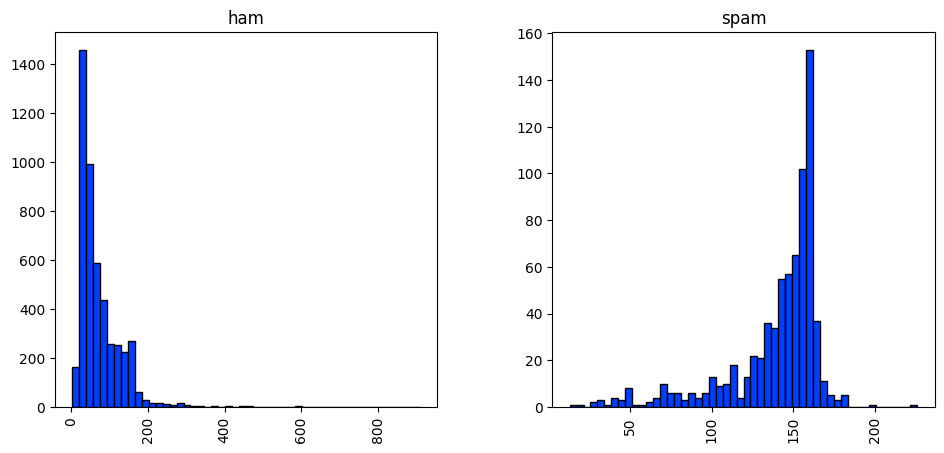

In [ ]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))

In [ ]:
text_feat = sms['message'].copy()

In [ ]:
def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

In [ ]:
text_feat = text_feat.apply(text_process)
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(text_feat)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

In [ ]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

In [ ]:
def train_classifier(clf, feature_train, labels_train):
    clf.fit(feature_train, labels_train)

In [ ]:
def predict_labels(clf, features):
    return (clf.predict(features))

In [ ]:
pred_scores = []
pred_dict={}
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))
    pred_dict[k]=[accuracy_score(labels_test,pred)]

In [ ]:
df = pd.DataFrame.from_dict(pred_dict,orient='index', columns=['Score'])
df

,Score
SVC,0.977871
KN,0.927632
NB,0.985048
DT,0.957536
LR,0.946770
RF,0.978469
AdaBoost,0.969498
BgC,0.967105
ETC,0.979665


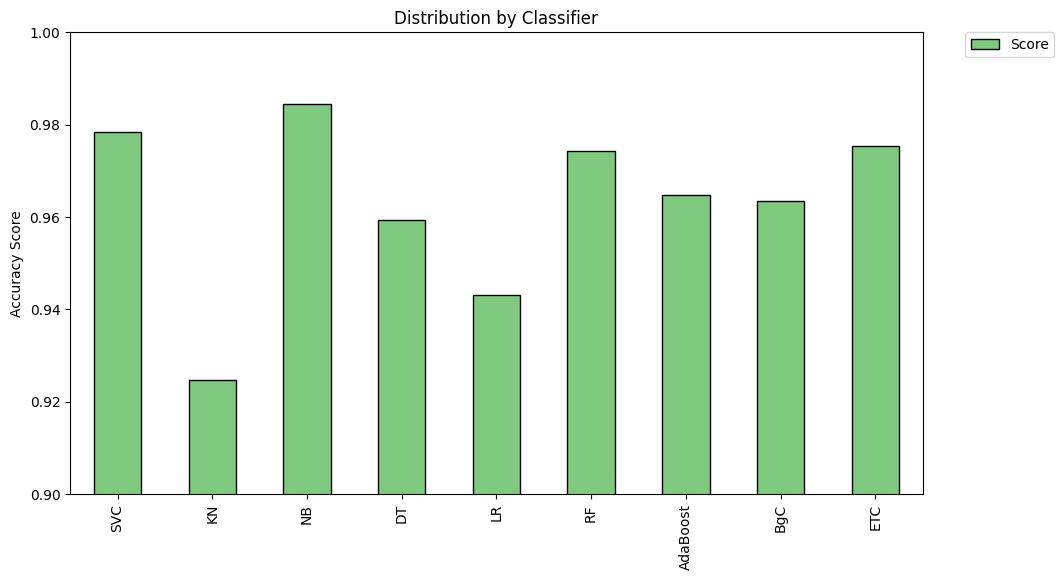

In [ ]:
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
def stemmer (text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

In [ ]:
text_feat = text_feat.apply(stemmer)
features = vectorizer.fit_transform(text_feat)
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

In [ ]:
pred_dict={}
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_dict[k]=[accuracy_score(labels_test,pred)]

In [ ]:
df2 = pd.DataFrame.from_dict(pred_dict,orient='index', columns=['Score2'])
df = pd.concat([df,df2],axis=1)
df

,Score,Score2
SVC,0.978469,0.977871
KN,0.924641,0.927632
NB,0.984450,0.985048
DT,0.959330,0.957536
LR,0.943182,0.946770
RF,0.974282,0.978469
AdaBoost,0.964713,0.969498
BgC,0.963517,0.967105
ETC,0.975478,0.979665


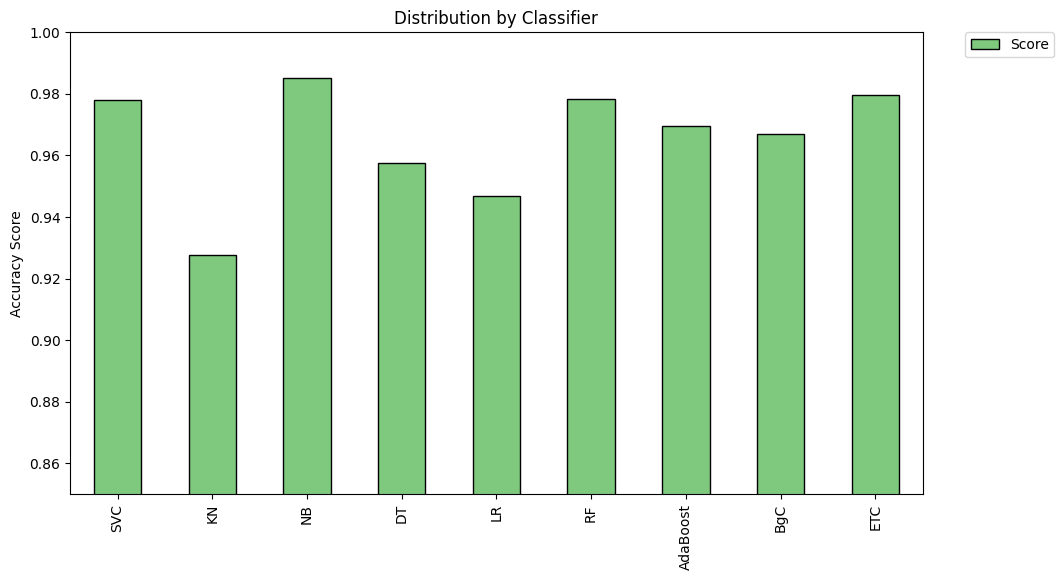

In [ ]:
df.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')

In [ ]:
eclf.fit(features_train,labels_train)

VotingClassifier(estimators=[('BgC',
                              BaggingClassifier(n_estimators=9,
                                                random_state=111)),
                             ('ETC',
                              ExtraTreesClassifier(n_estimators=9,
                                                   random_state=111)),
                             ('RF',
                              RandomForestClassifier(n_estimators=31,
                                                     random_state=111)),
                             ('Ada',
                              AdaBoostClassifier(n_estimators=62,
                                                 random_state=111))],
                 voting='soft')

In [ ]:
pred = eclf.predict(features_test)

In [ ]:
print(accuracy_score(labels_test,pred))

0.9820574162679426


# Определение спама при помощи моделей глубокого обучения

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
#Firstly we read our data
data = pd.read_csv("SPAM text message 20170820 - Data.csv")

In [ ]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
#We must change category 1 or 0
data["Category"] = [1 if each == "spam" else 0 for each in data["Category"]]

In [ ]:
data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
#We choose 1 row.And we throw punctuation
import re
nlp_data = str(data.iloc[2,:])
nlp_data = re.sub("[^a-zA-Z]"," ",nlp_data)

In [ ]:
#After return lower case
nlp_data = nlp_data.lower()

In [ ]:
#we have two choice we can use split methot or tokenize
import nltk as nlp
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nlp_data = nlp.word_tokenize(nlp_data)
#nlp_data = nlp_data.split() or we can do so

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#we have to find word root
lemma = nlp.WordNetLemmatizer()
nlp_data = [lemma.lemmatize(word) for word in nlp_data]

In [ ]:
#We join our data
nlp_data = " ".join(nlp_data)

In [ ]:
import nltk as nlp
import re
description_list = []
for description in data["Message"]:
    description = re.sub("[^a-zA-Z]"," ",description)
    description = description.lower()   # buyuk harftan kucuk harfe cevirme
    description = nlp.word_tokenize(description)
    #description = [ word for word in description if not word in set(stopwords.words("english"))]
    lemma = nlp.WordNetLemmatizer()
    description = [ lemma.lemmatize(word) for word in description]
    description = " ".join(description)
    description_list.append(description) #we hide all word one section

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

max_features = 3000  # Максимальное количество признаков (слов)

count_vectorizer = CountVectorizer(max_features=max_features, stop_words="english")
sparse_matrix = count_vectorizer.fit_transform(description_list).toarray()

print("The most common {} words: {}".format(max_features, count_vectorizer.get_feature_names_out()))

The most common 3000 words: ['aah' 'aathi' 'abi' ... 'zed' 'zindgi' 'zoe']


In [ ]:
#We separate our data is train and test
y = data.iloc[:,0].values   # male or female classes
x = sparce_matrix
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 42)

In [ ]:
#We make model for predict
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train,y_train)
print("the accuracy of our model: {}".format(nb.score(x_test,y_test)))

the accuracy of our model: 0.8763440860215054


In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 200)
lr.fit(x_train,y_train)
print("our accuracy is: {}".format(lr.score(x_test,y_test)))

our accuracy is: 0.974910394265233


In [1]:
from sklearn.neighbors import KNeighborsClassifier

# Инициализация классификатора k-ближайших соседей
knn = KNeighborsClassifier(n_neighbors=3)

# Преобразование данных к нужной форме
x_test = x_test.reshape(558, 3000)
x_train = x_train.reshape(5014, 3000)

# Обучение модели
knn.fit(x_train, y_train)

# Оценка точности модели на тестовом наборе данных
accuracy = knn.score(x_test, y_test)
print('With KNN (K=3) accuracy is: ', accuracy)

NameError: name 'x_test' is not defined